# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
%pip install optuna
%pip install category_encoders

     |████████████████████████████████| 404 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 81 kB 1.1 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna
import joblib

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

In [6]:
#Функция для проверки датасетов
def information(data):
    display(data.head())
    print(data.info())
    print('Количество дубликатов:', data['id'].duplicated().sum())
    print(f'''Пропусков:
{data.isna().sum()}''')
    display(data.describe())
    print(data.shape)

In [7]:
information(hotel_train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


(65229, 25)


In [8]:
information(hotel_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


(32412, 25)


In [9]:
hotel_train.dtypes == hotel_test.dtypes #Смотрим, одинаковы ли типы данных в датасетах

id                                True
is_canceled                       True
lead_time                         True
arrival_date_year                 True
arrival_date_month                True
arrival_date_week_number          True
arrival_date_day_of_month         True
stays_in_weekend_nights           True
stays_in_week_nights              True
adults                            True
children                          True
babies                            True
meal                              True
country                           True
distribution_channel              True
is_repeated_guest                 True
previous_cancellations            True
previous_bookings_not_canceled    True
reserved_room_type                True
booking_changes                   True
days_in_waiting_list              True
customer_type                     True
required_car_parking_spaces       True
total_of_special_requests         True
total_nights                      True
dtype: bool

In [10]:
#Проверим столбец со взрослыми постояльцами, где их количество равно нулю
zero_train = hotel_train.loc[(hotel_train['adults'] == 0) & (hotel_train['children'] == 0), 'adults']
print('Ноль постояльцев в hotel_train:', zero_train.count())

Ноль постояльцев в hotel_train: 15


In [11]:
zero_test = hotel_test.loc[(hotel_test['adults'] == 0) & (hotel_test['children'] == 0), 'adults']
print('Ноль постояльцев в hotel_test:', zero_test.count())

Ноль постояльцев в hotel_test: 7


In [12]:
categorical_columns = hotel_train.loc[:,  (hotel_train.dtypes == 'object')].columns #Список категориальных столбцов object

In [13]:
datas = [hotel_train, hotel_test] #Проверим категориальные столбцы на скрытые дубликаты
for data in datas:
    for column in categorical_columns:
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
Количество уникальных значений arrival_date_month: 12
['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']
Количество уникальных значений meal: 5
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM

Как видим, число уникальных значений в столбце meal должно быть 4, но их 5, они не совпадают, в тч из-за пробелов. Также есть пробелы в столбце distribution_channel. Нужно исправить. А в целом мы видим, что оба датасета абсолютно симметричные, типы данных одинаковы, дубликаты отсутствуют, пропусков нет. Столбец id нам не нужен. Удалим строки с нулевым количеством постояльцев.

### Шаг 2. Предобработка и исследовательский анализ данных

In [14]:
#Удаляем строки с нулевым количеством постояльцев
hotel_train = hotel_train.drop(zero_train.index).reset_index(drop=True)
hotel_test = hotel_test.drop(zero_test.index).reset_index(drop=True)

In [15]:
hotel_train.shape

(65214, 25)

In [16]:
datas = [hotel_train, hotel_test]
for data in datas: #Исправляем
    for column in ['meal', 'reserved_room_type']:
        data[column] = data[column].str.strip()
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7
['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7


In [17]:
#Удаляем id
hotel_train.drop(columns='id', inplace=True)
hotel_test.drop(columns='id', inplace=True)

Проверим на дубликаты без столбца id.

In [18]:
print(f'Дубликатов в hotel_train: {round(hotel_train.duplicated().mean() * 100, 2)}%')
print(f'Дубликатов в hotel_test: {round(hotel_test.duplicated().mean() * 100, 2)}%')

Дубликатов в hotel_train: 32.78%
Дубликатов в hotel_test: 23.81%


Ошеломляющий результат, причем, судя по признакам, это не может быть просто совпадением. Но это вполне могли быть несколько бронирований, сделанных одним клиентом в один день. Проверить наверняка мы это не можем. Поэтому удалять не будем.

# Исследовательский анализ

Далее исследуем наш целевой признак is_canceled, проверим его на выбросы, распределения и баланс.

In [19]:
colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(15, 5)}, palette=colors) #Задам настройки таблиц

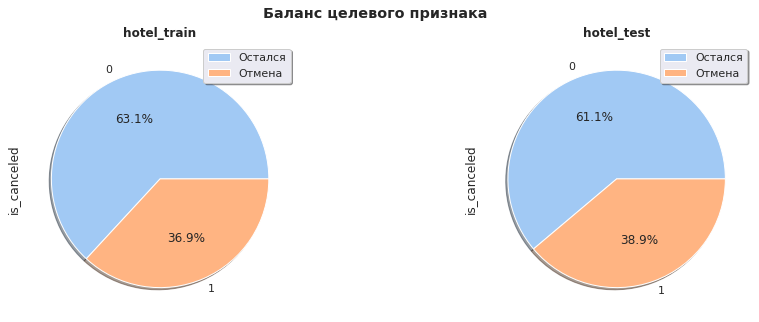

In [20]:
datas = [hotel_train, hotel_test]
titles = ['hotel_train', 'hotel_test']
fig, ax = plt.subplots(1, 2)
fig.suptitle('Баланс целевого признака', fontweight="bold")
AX = 0
for data in datas:
    data.is_canceled.value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%', ax=ax[AX])
    ax[AX].legend(['Остался', 'Отмена'], shadow=True)
    ax[AX].set_title(titles[AX], fontweight="bold")
    AX += 1
plt.show()

Мы наблюдаем некий дисбаланс целевого признака, который нужно в дальнейшем уравнять, хотя он не является критичным.

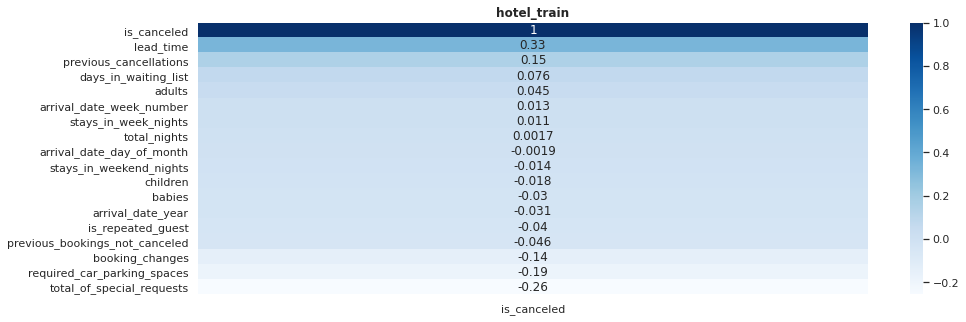

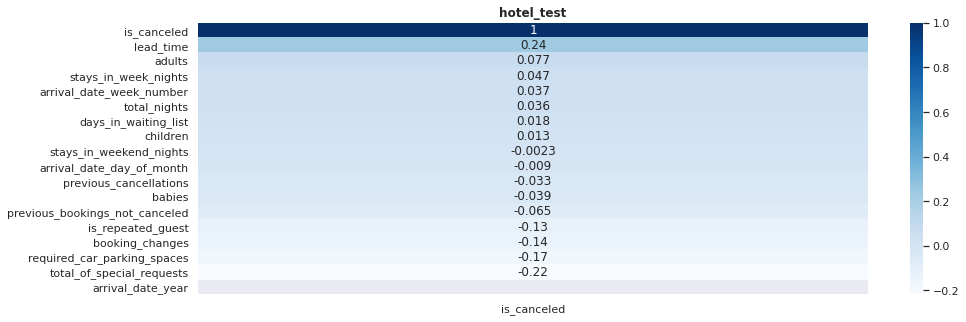

In [21]:
datas = [hotel_train, hotel_test]
AX = 0
for data in datas:
    sns.heatmap(data.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
    plt.title(titles[AX], fontweight="bold")
    AX += 1
    plt.show()

Выводы из изучения корреляций:

- Отрицательно (прямая зависимость) на ситуацию влияют такие показатели, как количество дней между датой бронирования и датой прибытия, количество взрослых постояльцев, количество дней ожидания подтверждения, неделя заезда. Графа количество отмененных заказов у клиента в тренировочной выборке имеет прямую зависимость с отменой бронирования, но внезапно в тестовой выборке - обратную зависимость. Возможно, за 2017 год у нас имеются неполные данные по этой графе.
- Положительно на ситуацию с отменой брони влияют такие показатели как количество специальных отметок, необходимость места для автомобиля, количество изменений параметров заказа, регулярность посещения гостем отеля и количество подтверждённых заказов у клиента.

Хотелось бы понять, равны ли совокупности столбца previous_cancellations в двух датасетах. Выдвинем гипотезы:

- Н0: Они равны
- Н1: Не равны

In [22]:
def hypothesis(data1, data2): #Создадим функцию, вдруг нам придется сравнивать совокупности в дальнейшем
    alpha = .05
    results = st.ttest_ind(data1, data2)
    print('p-значение:', results.pvalue / 2) #Делю на два, тк мне понадобится в дальнейшем односторонний тест
    if (results.pvalue / 2) < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Принимаем нулевую гипотезу')

In [23]:
hypothesis(hotel_train['previous_cancellations'], hotel_test['previous_cancellations'])

p-значение: 1.9059247199034706e-104
Отвергаем нулевую гипотезу


Получается, обе совокупности не равны. Это может сказаться на качестве предсказаний, учитывая, что в тренировочной выборке данный столбец демонстрирует высокий уровень корреляции с целевым признаком.

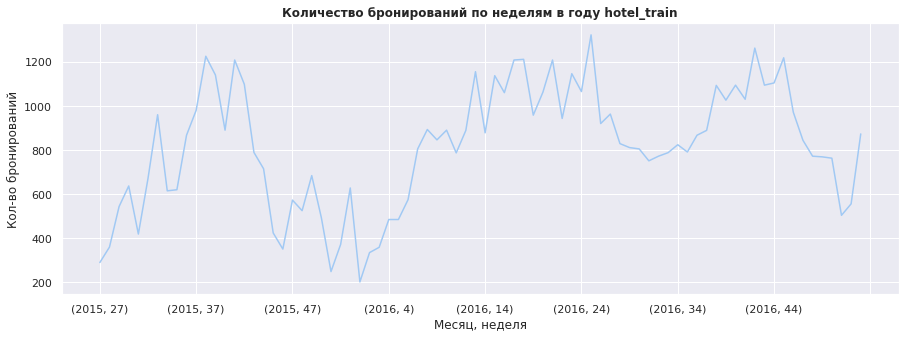

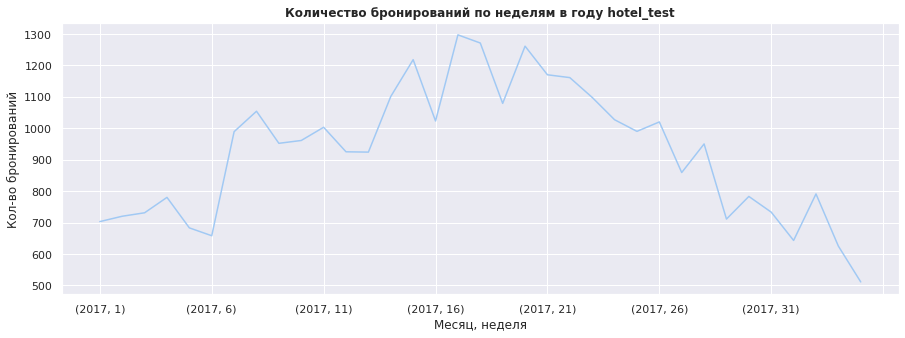

In [24]:
datas = [hotel_train, hotel_test]
AX = 0
for data in datas:
    data.pivot_table(index=['arrival_date_year', 'arrival_date_week_number'],
                            values='is_canceled', aggfunc='count').plot(legend=None)
    plt.xlabel('Месяц, неделя')
    plt.ylabel('Кол-во бронирований')
    plt.title(f'Количество бронирований по неделям в году {titles[AX]}', fontweight="bold")
    AX += 1
    plt.show()

Как видим, пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.

In [25]:
def distribution_plots(data, name, title): #Создадим функции для отображения распределения и ящика с усами
    fig, ax = plt.subplots(1, 2)
    fig.suptitle('Распределение ' + name, fontweight='bold', fontsize=20)
    sns.distplot(data, ax=ax[0])
    ax[0].set_ylabel('Плотность')
    ax[0].set_title(title, fontsize=18)
    
    sns.boxplot(data, ax=ax[1])
    ax[1].set_title(title, fontsize=18)
    plt.show()
def distribution(data, name):
    columns = [i for i in hotel_train.columns if (hotel_train[i].nunique() > 2) & (hotel_train[i].dtypes != 'object')]
    for column in columns:
        distribution_plots(data[column], name, column)

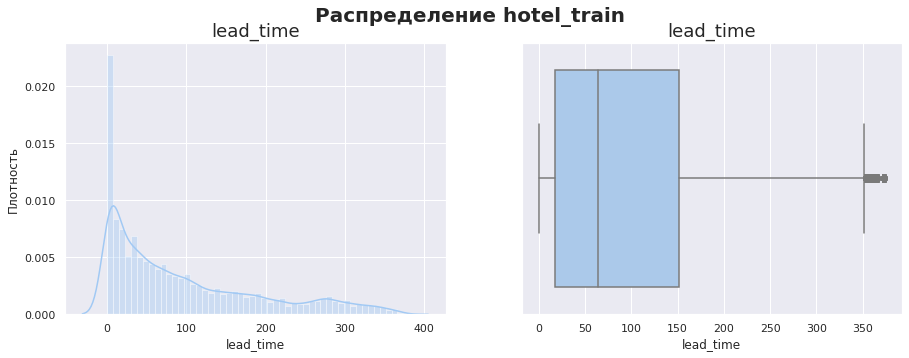

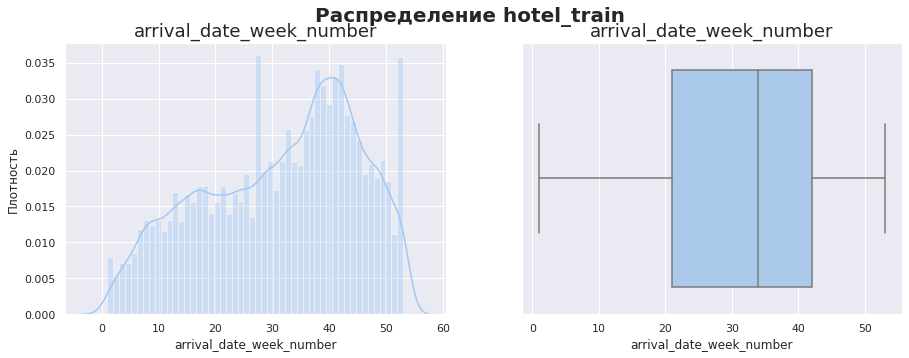

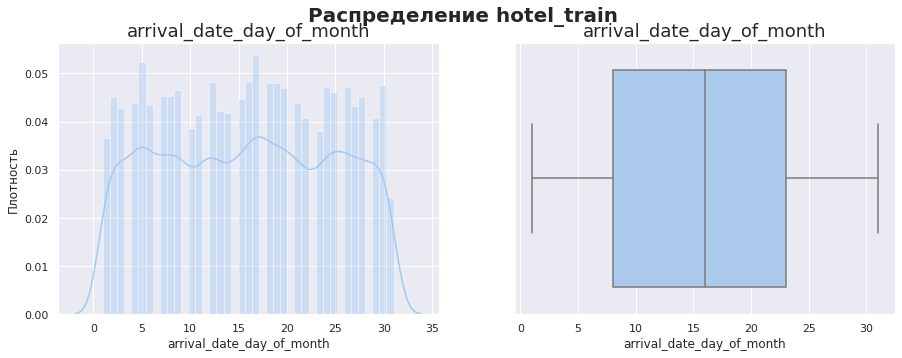

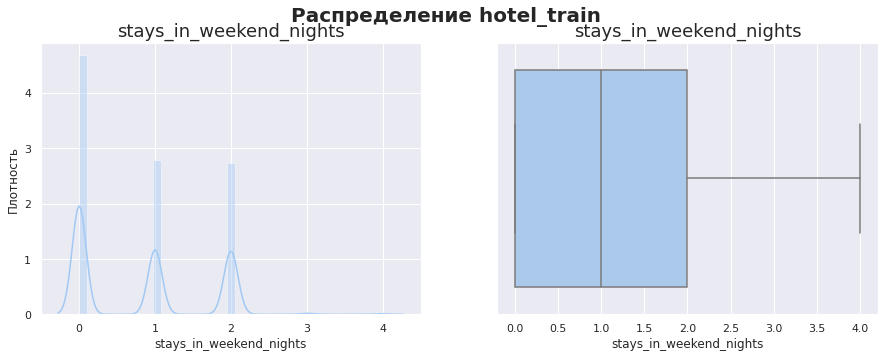

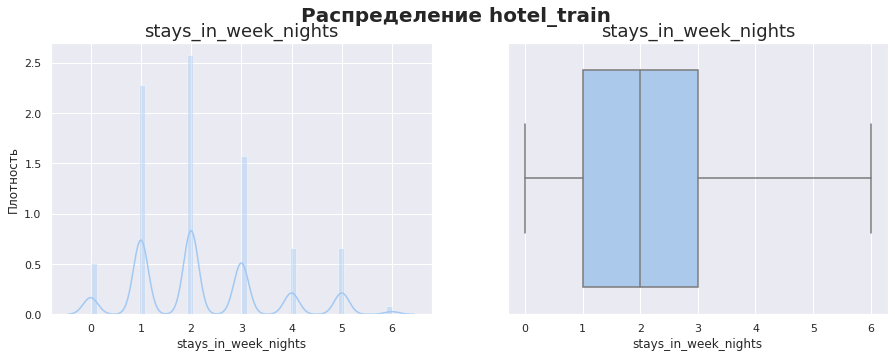

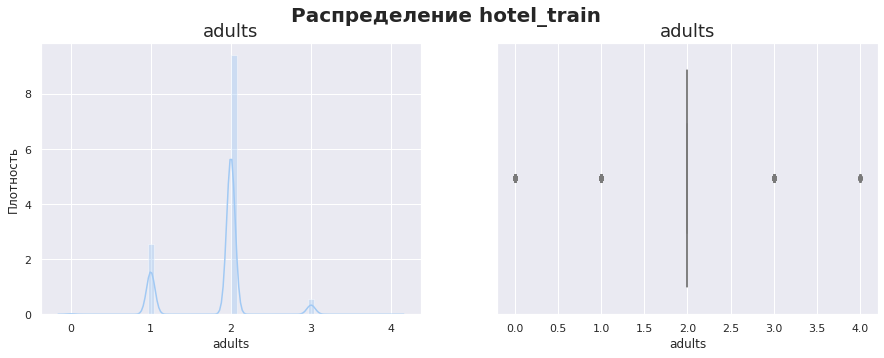

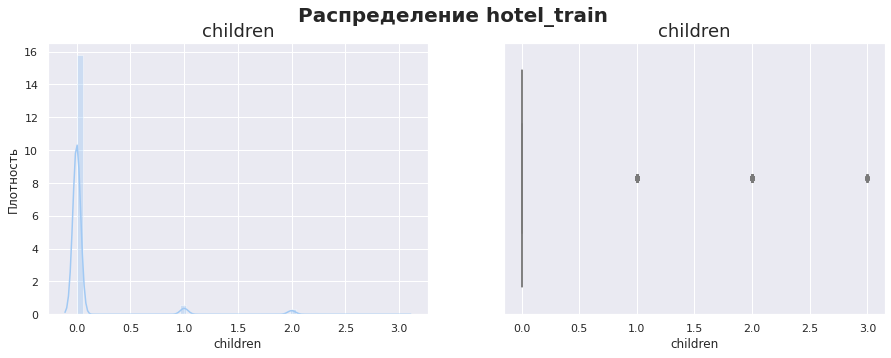

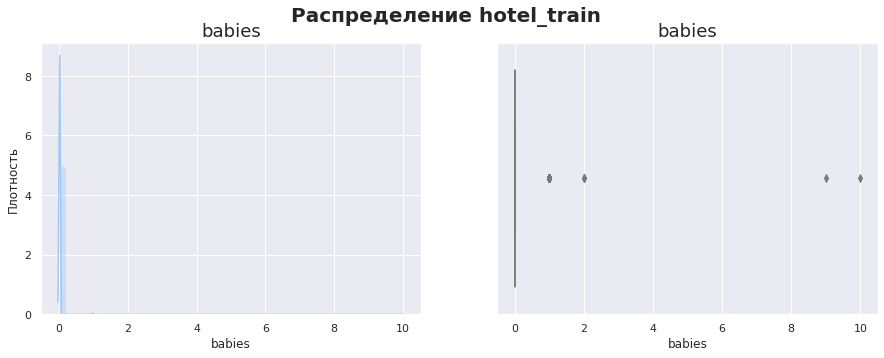

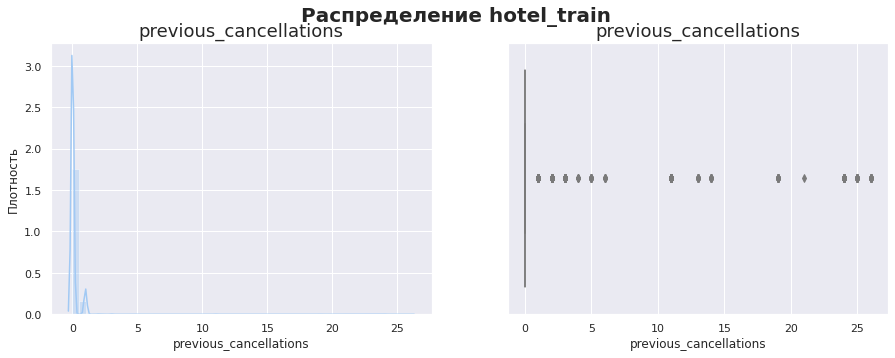

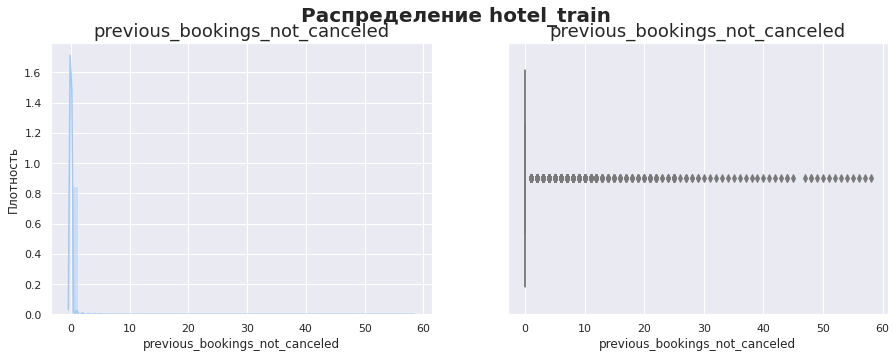

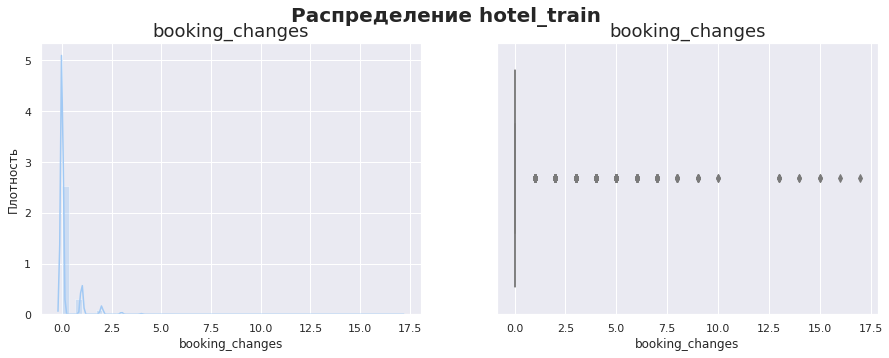

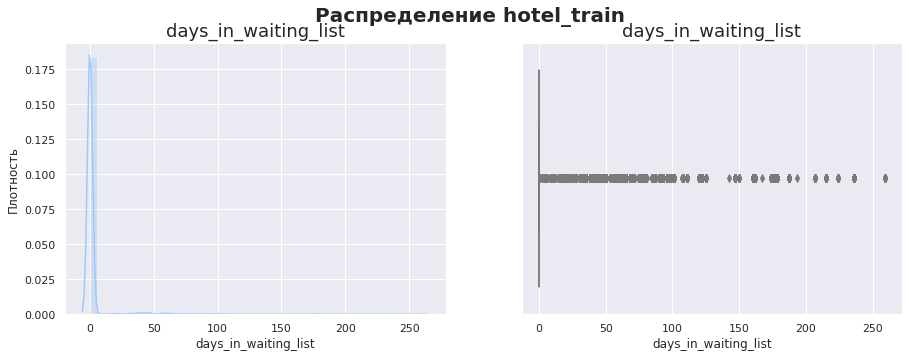

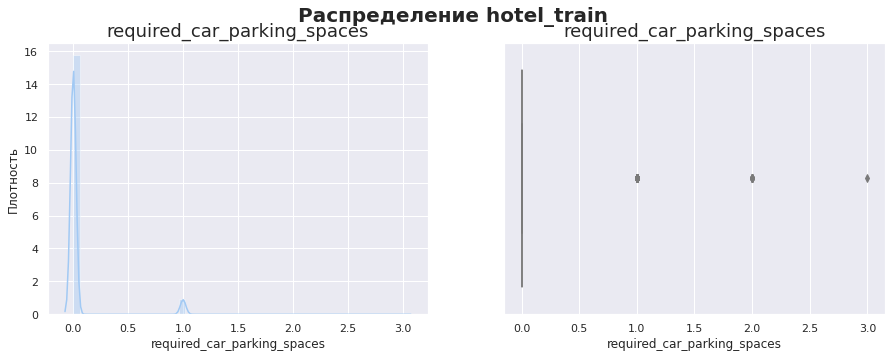

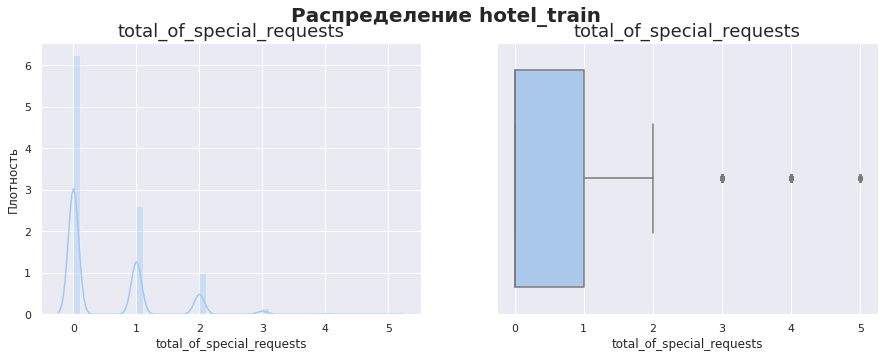

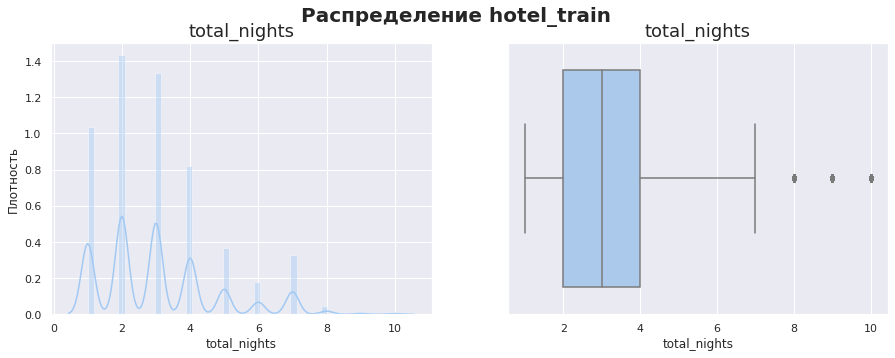

In [26]:
distribution(hotel_train, 'hotel_train')

Столбец с непрерывными значениями lead_time имеет логнормальное распределение и выбросы. Возможно, их стоит удалить. Также стоит скорректировать столбец total_nights. В других столбцах также есть искажения, которые являются нормой. Их мы трогать не будем.

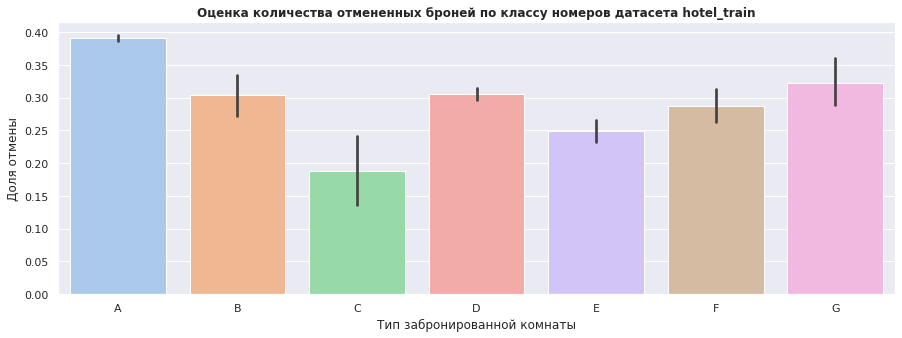

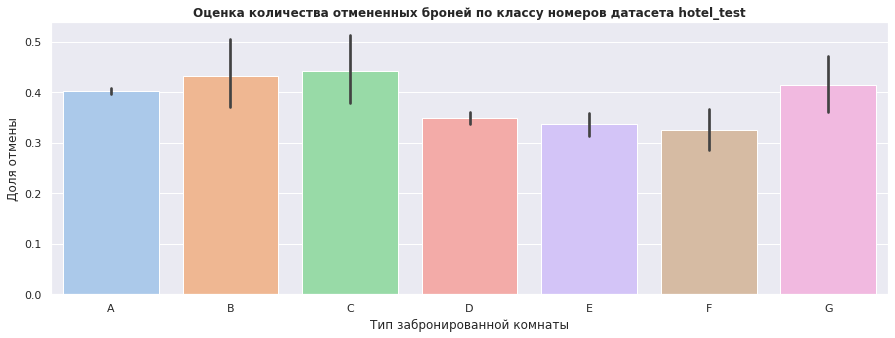

In [27]:
datas = [hotel_train, hotel_test]
AX = 0
for data in datas:
    sns.barplot(data=data, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
    plt.title(f'Оценка количества отмененных броней по классу номеров датасета {titles[AX]}', fontweight="bold")
    plt.xlabel('Тип забронированной комнаты')
    plt.ylabel('Доля отмены')
    AX += 1
    plt.show()

Как видим, в 2017 году (тренировочный датасет) было много отмен по классу В, D, F и G. На тестовой выборке много отмен по B, C, G. Признак А у нас стабильно в топе по отменам. Посмотрим на такой признак, как required_car_parking_spaces, там замечена высокая корреляция с сохранением бронирования номера.

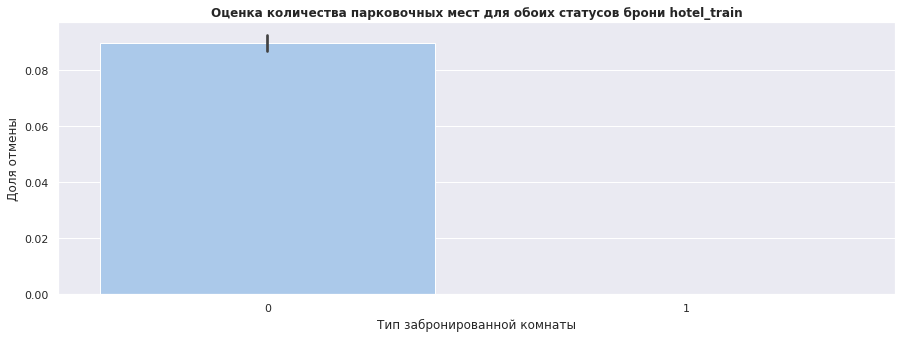

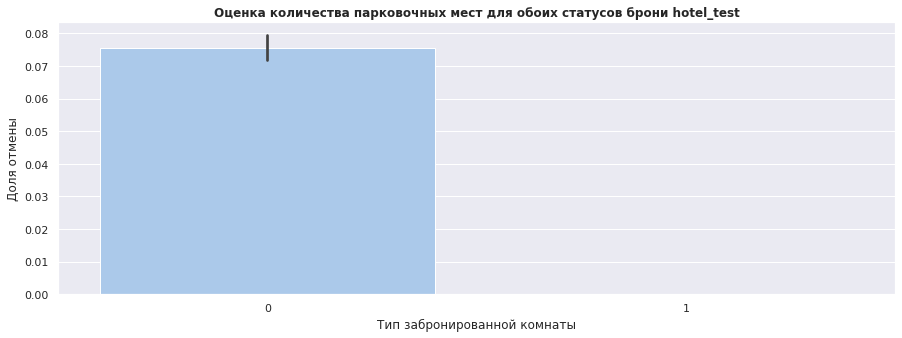

In [28]:
datas = [hotel_train, hotel_test]
AX = 0
for data in datas:
    sns.barplot(x=data['is_canceled'], y=data['required_car_parking_spaces'])
    plt.title(f'Оценка количества парковочных мест для обоих статусов брони {titles[AX]}', fontweight="bold")
    plt.xlabel('Тип забронированной комнаты')
    plt.ylabel('Доля отмены')
    AX += 1
    plt.show()

Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.

# Основные выводы

- Отменяется 37-39 % брони.
- Мы наблюдаем некий дисбаланс целевого признака, который нужно в дальнейшем уравнять, хотя он не является критичным.
- Отрицательно (прямая зависимость) на ситуацию оказывают такие показатели, как количество дней между датой бронирования и датой прибытия, количество взрослых постояльцев, количество дней ожидания подтверждения, неделя заезда. Графа количество отмененных заказов у клиента в тренировочной выборке имеет прямую зависимость с отменой бронирования, но внезапно в тестовой выборке - обратную зависимость. Возможно, за 2017 год у нас имеются неполные данные по этой графе.
- Положительно на ситуацию с отменой брони влияют такие показатели как количество специальных отметок, необходимость места для автомобиля, количество изменений параметров заказа, регулярность посещения гостем отеля и количество подтверждённых заказов у клиента.
- Пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.
- Столбец с непрерывными значениями lead_time имеет логнормальное распределение и выбросы. Имеет средний показатель 97,5. Этот признак больше всего коррелирует с целевым.
- Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.
- Класс номеров A (особенно), В, С и G традиционно находится в топе по отмене броней, тогда как E и F подвержены отмене меньше всего.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%. Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Прибыльность за отчётный период

Для начала соотнесем данные из наших датасетов с бизнес-метриками.

In [29]:
#Создадим отдельный дф с нужными признаками
df_for_profit = hotel_test[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
df_for_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,1,January,A,1
1,1,January,A,4
2,1,January,A,4
3,1,January,A,4
4,1,January,A,7


In [30]:
#Добавим к получившейся таблице значения стоимости комнат и обслуживания
room_dict = pd.DataFrame({'reserved_room_type' : [i for i in sorted(df_for_profit.reserved_room_type.unique())],
                         'price_per_night' : [1000, 800, 600, 550, 500, 450, 350],
                         'service_price' : [400, 350, 350, 150, 150, 150, 150]})
df_for_profit = df_for_profit.merge(room_dict, on='reserved_room_type', how='left')

In [31]:
#Добавим коэффициенты по сезону
month_dict = pd.DataFrame({'arrival_date_month' : [i for i in df_for_profit.arrival_date_month.unique()],
                          'koeff' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]})
df_for_profit = df_for_profit.merge(month_dict, on='arrival_date_month', how='left')
df_for_profit

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,koeff
0,1,January,A,1,1000,400,1.0
1,1,January,A,4,1000,400,1.0
2,1,January,A,4,1000,400,1.0
3,1,January,A,4,1000,400,1.0
4,1,January,A,7,1000,400,1.0
...,...,...,...,...,...,...,...
32400,0,August,A,6,1000,400,1.4
32401,0,August,A,7,1000,400,1.4
32402,0,August,A,7,1000,400,1.4
32403,0,August,D,7,550,150,1.4


In [32]:
#Далее создадим функцию для рассчета прибыли и убытка в зависимости от отмены брони
def profit(data):
    if data['is_canceled'] == 0:
        income = data['price_per_night'] * data['koeff'] * data['total_nights']
        expenses = data['service_price'] * (1 + data['total_nights'] // 2)
    else:
        income = 0
        expenses = data['service_price'] + (data['price_per_night'] * data['koeff'])
    profit = income - expenses
    return profit

In [33]:
df_for_profit['total_profit'] = df_for_profit.apply(profit, axis=1)

In [34]:
display(df_for_profit)
profit_without_deposite = df_for_profit['total_profit'].sum()
print('Прибыль с января по август 2017 г. без депозита составляет:', profit_without_deposite, 'руб.')

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,koeff,total_profit
0,1,January,A,1,1000,400,1.0,-1400.0
1,1,January,A,4,1000,400,1.0,-1400.0
2,1,January,A,4,1000,400,1.0,-1400.0
3,1,January,A,4,1000,400,1.0,-1400.0
4,1,January,A,7,1000,400,1.0,-1400.0
...,...,...,...,...,...,...,...,...
32400,0,August,A,6,1000,400,1.4,6800.0
32401,0,August,A,7,1000,400,1.4,8200.0
32402,0,August,A,7,1000,400,1.4,8200.0
32403,0,August,D,7,550,150,1.4,4790.0


Прибыль с января по август 2017 г. без депозита составляет: 32561070.0 руб.


Итак, прибыль за отчестный период у нас составила 32_561_070 руб. Теперь примемся за разработку ML модели, которая поможет нам окупить затраты на разработку модели и ее внедрение, а также принести прибыль. Для этого подготовим данные.

# Подготавка данных для ML

Создадим копию наших датасетов, чтобы не менять наши данные в дальнейшем, из копий удалим выбросы, разделим на фичи и таргет, затем преобразуем.

Удалим выбросы из столбцов lead_time и total_nights, чтобы корректно обучить наши модели.

In [35]:
#Делаем копию
hotel_train_trans = hotel_train.copy()

In [36]:
def remove_out(data, column): #Создаем функцию для удаления выбросов
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    upper = data.loc[data[column] >= (q3 + 1.5 * iqr)].index
    lower = data.loc[data[column] <= (q1 - 1.5 * iqr)].index
    data.drop(upper, inplace=True)
    data.drop(lower, inplace=True)

In [37]:
iter_rows = 0
while iter_rows != hotel_train_trans.shape[0]:
    iter_rows = hotel_train_trans.shape[0]
    remove_out(hotel_train_trans, 'total_nights')
    remove_out(hotel_train_trans, 'lead_time')

In [38]:
hotel_train_trans.shape

(53311, 24)

In [39]:
#Делим выборки
features_train, target_train = hotel_train_trans.drop(columns='is_canceled', axis=1), hotel_train_trans['is_canceled']
features_test, target_test = hotel_test.drop(columns='is_canceled', axis=1), hotel_test['is_canceled']

Заметно, что некоторые столбцы, как, например children и babies лучше привести к булевым значениям для того, чтобы подчеркнуть корреляцию.

In [40]:
def category(value):
    if value == 0:
        return False
    else:
        return True
for data, column in [(features_train, 'babies'), (features_test, 'babies'), (features_train, 'children'), 
                     (features_test, 'children')]:
    data[column] = data[column].apply(category)

In [41]:
#Признак arrival_date_year удалим, тк он не коррелирует с целевыми признаками и может быть выражен одним столбцом
#arrival_date_week_number, так что не будем размывать корреляции
features_train.drop(columns=['arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_month', 'total_nights'], inplace=True)
features_test.drop(columns=['arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_month', 'total_nights'], inplace=True)

Отмасштабируем данные для регрессии

In [42]:
numeric = [*features_train.select_dtypes(exclude=['object']).columns]
numeric.remove('is_repeated_guest')
numeric.remove('babies')
numeric.remove('children')
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [43]:
binary = ce.BinaryEncoder()
binary.fit(features_train)
features_train = binary.transform(features_train)
features_test = binary.transform(features_test)

In [44]:
display(features_train)

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal_0,meal_1,meal_2,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_0,distribution_channel_1,distribution_channel_2,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests
0,-0.930833,-0.274580,-0.927239,-0.856982,-1.627206,False,False,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
1,-0.821137,-0.274580,-0.927239,0.016266,0.359556,False,False,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,0.590661
2,-1.040529,-0.274580,-0.927239,0.016266,0.359556,False,False,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,-0.106659,-0.089039,0,1,0,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
3,-0.899491,-0.274580,-0.927239,0.016266,0.359556,False,False,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.106659,-0.089039,0,1,0,-0.333967,-0.187525,0,0,1,-0.259158,0.590661
4,0.291491,-0.274580,-0.927239,0.889513,0.359556,False,False,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,0.590661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65207,0.463870,1.576742,1.570590,0.889513,0.359556,False,False,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
65208,-0.680100,1.576742,1.570590,1.762760,0.359556,False,False,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,-0.106659,-0.089039,0,1,1,-0.333967,-0.187525,0,0,1,-0.259158,1.897737
65209,-0.680100,1.576742,1.570590,1.762760,0.359556,False,False,0,0,1,0,0,0,1,1,1,1,0,0,1,0,0,-0.106659,-0.089039,0,1,1,-0.333967,-0.187525,0,0,1,-0.259158,1.897737
65210,-0.209975,1.576742,1.570590,0.889513,0.359556,False,False,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,-0.106659,-0.089039,0,1,1,-0.333967,-0.187525,0,0,1,-0.259158,3.204812


In [45]:
display(features_test)

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal_0,meal_1,meal_2,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_0,distribution_channel_1,distribution_channel_2,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests
0,0.119112,-2.125901,0.321675,-1.730229,0.359556,False,False,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
1,-0.068938,-2.125901,1.570590,0.016266,0.359556,False,False,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,0.590661
2,-0.068938,-2.125901,1.570590,0.016266,0.359556,False,False,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,0.590661
3,0.072100,-2.125901,1.570590,0.016266,-1.627206,False,False,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,0.590661
4,1.654853,-2.125901,1.570590,2.636007,0.359556,False,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32400,1.529486,0.295058,1.570590,1.762760,0.359556,False,False,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
32401,-0.711441,0.295058,1.570590,2.636007,0.359556,False,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,1.897737
32402,-0.680100,0.295058,1.570590,2.636007,0.359556,False,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,-0.106659,-0.089039,0,0,1,-0.333967,-0.187525,0,0,1,-0.259158,-0.716414
32403,-0.507721,0.295058,1.570590,2.636007,0.359556,False,False,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,-0.106659,-0.089039,0,1,1,-0.333967,-0.187525,0,0,1,-0.259158,4.511887


Увеличение обучающей выборки

Данные готовы, признаки разделены, преобразованы. Сделали масштабирование. Увеличим тренировочную выборку за счет добавления положительного признака и начнем строить ML-модели.

In [46]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train, target_train = upsample(features_train, target_train, 2)

In [47]:
features_train.shape[0] / features_test.shape[0]

2.1794167566733527

In [48]:
target_train.value_counts()

0    35998
1    34626
Name: is_canceled, dtype: int64

### Шаг 4. Разработка модели ML

# Выбор лучшей модели

Далее нужно выбрать из них самую качественную, ту, которая удовлетворяла бы нашим условиям. Целевой показатель для нас - recall - тк именно отказники, которым модель ошибочно присвоит ложный признак, принесут убытки отелю.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Верно, молодец! Метрика, которую мы будем "выращивать" выбрана!
</div>

In [81]:
#Строим дамми для проверки на адекватность
dummy_model = DummyClassifier(random_state=1)
dummy_model.fit(features_train, target_train)
prediction_dummy = dummy_model.predict(features_test)
dummy_proba = dummy_model.predict_proba(features_test)[:, 1]
print("Accuracy:", accuracy_score(target_test, prediction_dummy))
print("F1:", f1_score(target_test, prediction_dummy))
print("ROC_auc:", roc_auc_score(target_test, dummy_proba))
fpr_dummy, tpr_dummy, threshold_dummy = roc_curve(target_test, dummy_proba)

Accuracy: 0.6114488504860361
F1: 0.0
ROC_auc: 0.5


In [50]:
#Строим функцию для постройки ROC-AUC графика
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [85]:
#Функция для сверки результатов
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("Accuracy:", round(accuracy_score(target, prediction), 3))
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, proba_one), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))
    return prediction

In [86]:
#Сделаем график кроссвалидации чтобы понять, что наши результаты стабильны и не случайны
def cross_val_plot(model, features, target):
    plt.plot(cross_val_score(model, features, target, cv=10, scoring='recall', n_jobs=-1))
    plt.title('Показатели Recall по блокам кроссвалидации')
    plt.xlabel('Блок')
    plt.ylabel('Метрика Recall')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.show()

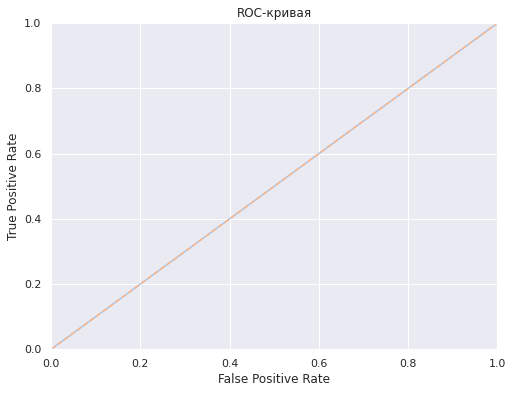

Accuracy: 0.611
F1: 0.0
ROC_auc: 0.5
Precision: 0.0
Recall: 0.0


In [87]:
dummy_pred = results(dummy_model, features_test, target_test) #Строим ROC-AUC для Dummy Classifier

# Logistic Regression

In [54]:
model_lr = LogisticRegression(random_state=1, solver='liblinear', n_jobs=-1, class_weight='balanced')
model_lr.fit(features_train, target_train)
print('Кросс-валидац Recall:', cross_val_score(model_lr, features_train, target_train, cv=5, scoring='recall').mean())

Кросс-валидац Recall: 0.7384622919340194


In [55]:
#print(f'Лучший Recall на обучающей выборке: {model_lr.score(features_train, target_train)}')
print(f'Лучший Recall на тестовой выборке: {model_lr.score(features_test, target_test)}')

Лучший Recall на тестовой выборке: 0.7258139176053078


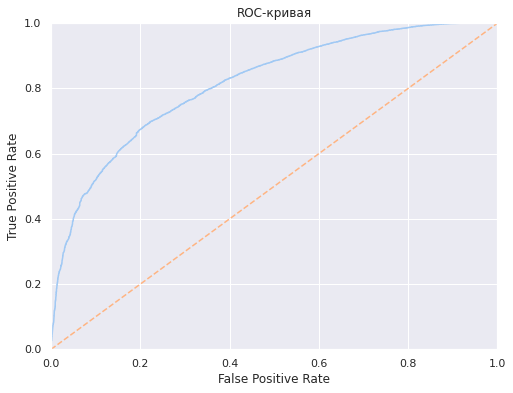

Accuracy: 0.726
F1: 0.679
ROC_auc: 0.73
Precision: 0.623
Recall: 0.747


In [56]:
prediction_lr = results(model_lr, features_test, target_test)

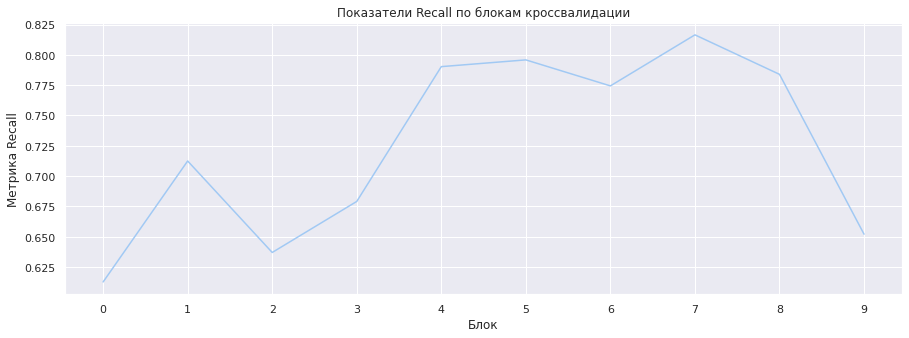

In [57]:
cross_val_plot(model_lr, features_test, target_test)

In [58]:
model_lr.class_weight

'balanced'

# Decision Tree

In [59]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 60, 10)
    model_dt = DecisionTreeClassifier(random_state=1, criterion=criterion, 
                                     max_depth=max_depth, 
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight='balanced'
                                     )
    model_dt.fit(features_train, target_train)
    trial.set_user_attr(key="best_booster", value=model_dt)
    cross_valid = cross_val_score(model_dt, features_train, target_train, cv=5, scoring='recall', n_jobs=-1).mean()
    return cross_valid

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, callbacks=[callback])
model_dt = study.user_attrs["best_booster"]
print('Recall:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-09-30 14:15:45,947] A new study created in memory with name: no-name-5fbda4c0-45f1-4069-b0c6-f11938864bce
[I 2023-09-30 14:15:47,366] Trial 0 finished with value: 0.6064530639008977 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 60}. Best is trial 0 with value: 0.6064530639008977.
[I 2023-09-30 14:15:49,288] Trial 1 finished with value: 0.7959052552460201 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.7959052552460201.
[I 2023-09-30 14:15:50,818] Trial 2 finished with value: 0.7025644382961289 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.7959052552460201.
[I 2023-09-30 14:15:52,732] Trial 3 finished with value: 0.7934505483966137 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 60}. Best is trial 1 with value: 0.7959052552460201.
[I 2023-09-30 14:15:54,600] Trial 4 finished with value: 0.795

Recall: 0.817969407381384 с параметрами: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 30}


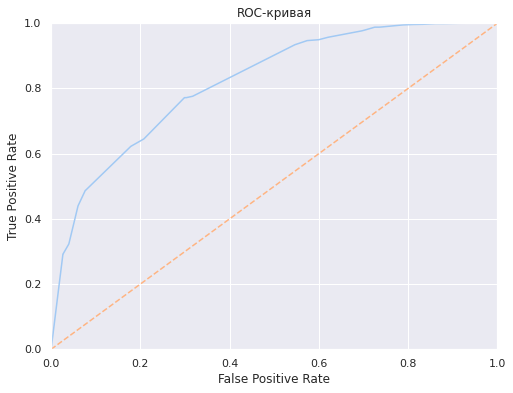

Accuracy: 0.729
F1: 0.688
ROC_auc: 0.736
Precision: 0.621
Recall: 0.772


In [60]:
prediction_dt = results(model_dt, features_test, target_test)

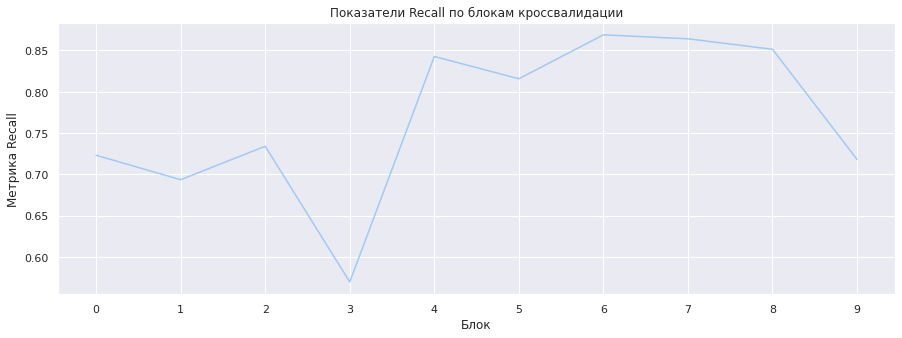

In [61]:
cross_val_plot(model_dt, features_test, target_test)

# Random Forest

In [62]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy'])
    n_estimators = trial.suggest_int('n_estimators', 3, 9, 3)
    max_depth = trial.suggest_int('max_depth', 25, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 50, 10)
    rf_model = RandomForestClassifier(random_state=1, criterion=criterion, 
                                     max_depth=max_depth, 
                                     n_estimators=n_estimators, 
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight='balanced'
                                     )
    rf_model.fit(features_train, target_train)
    trial.set_user_attr(key="best_booster", value=rf_model)
    cross_valid = cross_val_score(rf_model, features_train, target_train, cv=5, scoring='recall', n_jobs=-1).mean()
    return cross_valid

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[callback])
model_rf = study.user_attrs["best_booster"]
print('Recall:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-09-30 14:18:38,684] A new study created in memory with name: no-name-11b7b458-9b66-4a7a-8da3-d21e2c04bbc8
[I 2023-09-30 14:18:40,374] Trial 0 finished with value: 0.7585620697815274 and parameters: {'criterion': 'entropy', 'n_estimators': 3, 'max_depth': 30, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.7585620697815274.
[I 2023-09-30 14:18:43,348] Trial 1 finished with value: 0.7882226278627805 and parameters: {'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 30, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.7882226278627805.
[I 2023-09-30 14:18:46,205] Trial 2 finished with value: 0.7689305051545425 and parameters: {'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 27, 'min_samples_leaf': 50}. Best is trial 1 with value: 0.7882226278627805.
[I 2023-09-30 14:18:48,666] Trial 3 finished with value: 0.8028360085108069 and parameters: {'criterion': 'entropy', 'n_estimators': 6, 'max_depth': 29, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.

Recall: 0.8031538564984555 с параметрами: {'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 30, 'min_samples_leaf': 10}


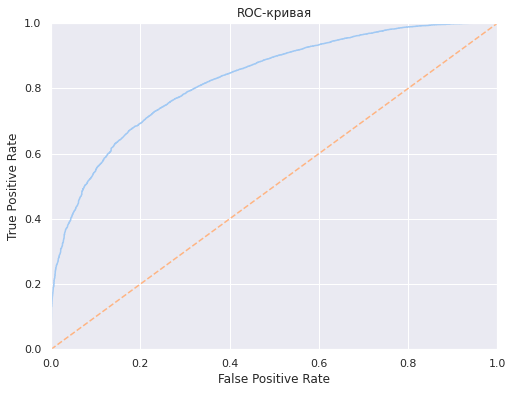

Accuracy: 0.767
F1: 0.682
ROC_auc: 0.744
Precision: 0.727
Recall: 0.641


In [63]:
prediction_rf = results(model_rf, features_test, target_test)

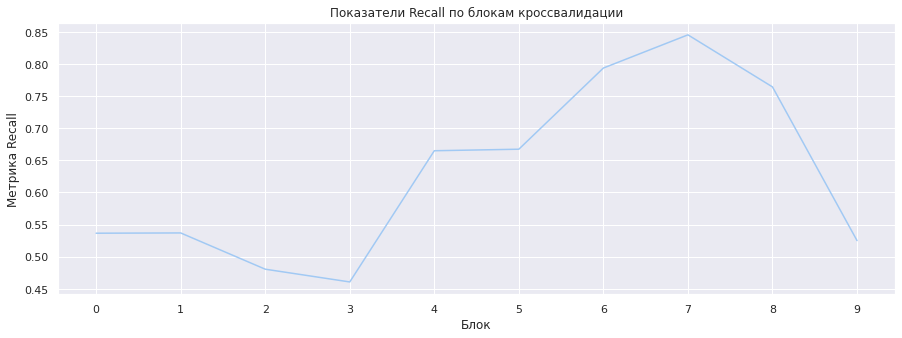

In [64]:
cross_val_plot(model_rf, features_test, target_test)

Все метрики уместим в одной компактной таблице. Из них выберем лучшую на основании метрики recall, и обратим внимание на f1

In [65]:
best_metrics = pd.DataFrame(data=[('Logistic Regression', round(accuracy_score(target_test, prediction_lr), 3), 
                                  round(f1_score(target_test, prediction_lr), 3), 
                                  round(roc_auc_score(target_test, prediction_lr), 3),
                                  round(precision_score(target_test, prediction_lr), 3), 
                                  round(recall_score(target_test, prediction_lr), 3)),
                                 ('Decision Tree', round(accuracy_score(target_test, prediction_dt), 3), 
                                  round(f1_score(target_test, prediction_dt), 3), 
                                  round(roc_auc_score(target_test, prediction_dt), 3),
                                  round(precision_score(target_test, prediction_dt), 3), 
                                  round(recall_score(target_test, prediction_dt), 3)), 
                                 ('Random Forest', round(accuracy_score(target_test, prediction_rf), 3), 
                                  round(f1_score(target_test, prediction_rf), 3), 
                                  round(roc_auc_score(target_test, prediction_rf), 3),
                                  round(precision_score(target_test, prediction_rf), 3), 
                                  round(recall_score(target_test, prediction_rf), 3))],
                                 columns=['model', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
best_metrics

,model,accuracy,f1,roc_auc,precision,recall
0,Logistic Regression,0.726,0.679,0.730,0.623,0.747
1,Decision Tree,0.729,0.688,0.736,0.621,0.772
2,Random Forest,0.767,0.682,0.744,0.727,0.641


Как мы видим, все три модели качественны и адекватны.

Мы пострили три модели, и, как видим, все три достаточно работоспособны. Кроссвалидацию делали по метрике ROC AUC.

- Первая - логистическая регрессия. Показатель кроссвалидации 0.8339893308930117. Метрики на тестовой выборке: Accuracy: 0.726, F1: 0.679, ROC_auc: 0.73, Precision: 0.623, Recall: 0.747.
- Далее сделали дерево решений с показателем кроссвалидации Recall: 0.8034712124355357 с параметрами: {'criterion': 'entropy', 'n_estimators': 6, 'max_depth': 25, 'min_samples_leaf': 10}. Метрики на тестовой выборке: Accuracy: 0.729, F1: 0.688, ROC_auc: 0.736, Precision: 0.621, Recall: 0.772.
- Замыкает случайный лес. Показатель кроссвалидации Recall: 0.7735804330670493 с параметрами: {'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 25, 'min_samples_leaf': 50}. Метрики на тестовой выборке: Accuracy: 0.763, F1: 0.681, ROC_auc: 0.743, Precision: 0.712, Recall: 0.653.
- Все модели адекватны в сравнении с DummyClassifier.
- У Random Forest слишком волатильные показатели recall в блоках кроссвалидации на тестовой выборке. Не говоря о том, что recall самый низкий, хотя модель лучше в целом.

Как видим по показателям кроссвалидации на основе метрики recall, нас устраивает модель Decision Tree с показателем 0,818. Проверка на тествой выборке подсказывает нам, что выбор правильный, модель качественна и адекватна.

Подтверждение выбранной модели и проверка на бизнес-метрике

Особенно для себя отметим метрику F1 и recall в частности. Проверим более наглядно на хитмэпе.

In [66]:
def heatmatrix(title, prediction):
    sns.heatmap(confusion_matrix(target_test, prediction), annot=True, cmap='Blues', fmt='g', 
               xticklabels=['Не отмена', 'Отмена'], yticklabels=['Не отмена', 'Отмена'])
    plt.title(f'Матрица ошибок {title}')
    plt.xlabel('Предсказания')
    plt.ylabel('Правильные ответы')
    plt.show()

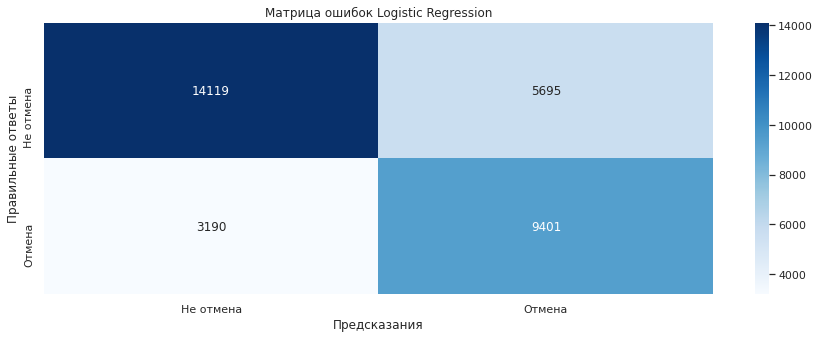

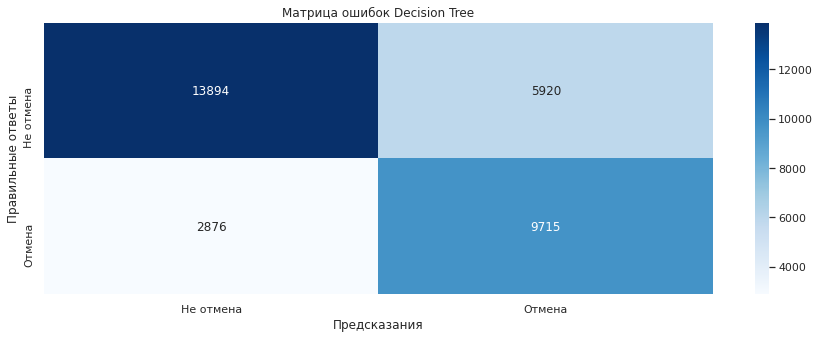

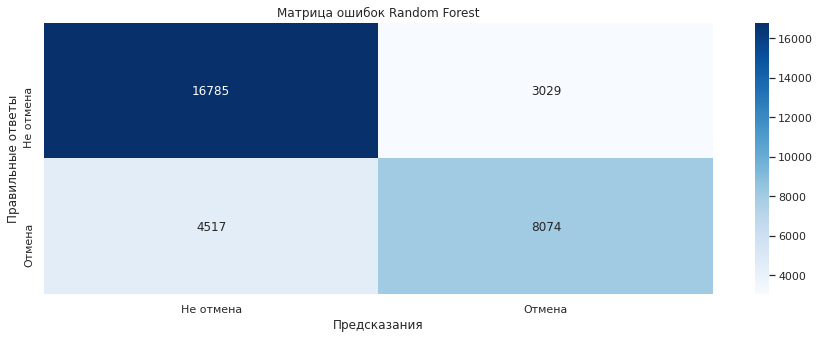

In [67]:
models = [('Logistic Regression', prediction_lr), ('Decision Tree', prediction_dt), ('Random Forest', prediction_rf)]
for title, prediction in models:
    heatmatrix(title, prediction)


Лог регресия и дерево предсказывают очень хорошо наш целевой показатель. Проверим, какая модель принесет больше прибыли.

In [68]:
predictions = [('prediction_lr', prediction_lr), ('prediction_dt', prediction_dt), ('prediction_rf', prediction_rf)]
for name, prediction in predictions:
    series = pd.Series(prediction).to_frame()
    series.columns = [name]
    df_for_profit = df_for_profit.merge(series, how='left', left_index=True, right_index=True)

In [69]:
def predicted_profit(data, col):
    if data['is_canceled'] == 0:
        income = data['price_per_night'] * data['koeff'] * data['total_nights']
        expenses = data['service_price'] * (1 + data['total_nights'] // 2)
    elif (data['is_canceled'] == 1) and (data[col] == 0):
        income = 0
        expenses = data['service_price'] + (data['price_per_night'] * data['koeff'])
    elif (data['is_canceled'] == 1) and (data[col] == 1):
        income = (data['price_per_night'] * data['koeff'] * .8) + (data['service_price'] * .8)
        expenses = data['service_price'] + (data['price_per_night'] * data['koeff'])
    profit = income - expenses
    return profit

In [70]:
for new_col, col in [('profit_lr', 'prediction_lr'), ('profit_dt', 'prediction_dt'), ('profit_rf', 'prediction_rf')]:
    df_for_profit[new_col] = df_for_profit.apply(predicted_profit, col=col, axis=1)

In [71]:
display(df_for_profit)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,koeff,total_profit,prediction_lr,prediction_dt,prediction_rf,profit_lr,profit_dt,profit_rf
0,1,January,A,1,1000,400,1.0,-1400.0,1,1,1,-280.0,-280.0,-280.0
1,1,January,A,4,1000,400,1.0,-1400.0,0,0,0,-1400.0,-1400.0,-1400.0
2,1,January,A,4,1000,400,1.0,-1400.0,0,0,0,-1400.0,-1400.0,-1400.0
3,1,January,A,4,1000,400,1.0,-1400.0,1,1,1,-280.0,-280.0,-280.0
4,1,January,A,7,1000,400,1.0,-1400.0,1,1,0,-280.0,-280.0,-1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32400,0,August,A,6,1000,400,1.4,6800.0,1,1,0,6800.0,6800.0,6800.0
32401,0,August,A,7,1000,400,1.4,8200.0,0,0,0,8200.0,8200.0,8200.0
32402,0,August,A,7,1000,400,1.4,8200.0,0,1,1,8200.0,8200.0,8200.0
32403,0,August,D,7,550,150,1.4,4790.0,0,0,0,4790.0,4790.0,4790.0


In [72]:
print('Прибыль после обучения LR:', df_for_profit['profit_lr'].sum())
print('Прибыль после обучения DT:', df_for_profit['profit_dt'].sum())
print('Прибыль после обучения RF:', df_for_profit['profit_rf'].sum())

Прибыль после обучения LR: 43494206.0
Прибыль после обучения DT: 43796390.0
Прибыль после обучения RF: 41977902.0


In [73]:
print('Прибыль от использования LR:', (df_for_profit['profit_lr'].sum() - df_for_profit['total_profit'].sum()))
print('Прибыль от использования DT:', (df_for_profit['profit_dt'].sum() - df_for_profit['total_profit'].sum()))
print('Прибыль от использования RF:', (df_for_profit['profit_rf'].sum() - df_for_profit['total_profit'].sum()))

Прибыль от использования LR: 10933136.0
Прибыль от использования DT: 11235320.0
Прибыль от использования RF: 9416832.0


Выдвинем гипотезу относительно модели Decision Tree:

- Н0: Средняя прибыль не изменилась
- Н1: Средняя прибыль увеличилась

In [74]:
hypothesis(df_for_profit['total_profit'], df_for_profit['profit_dt'])

p-значение: 9.144778240650904e-87
Отвергаем нулевую гипотезу


Прибыль, скорее всего, увеличится, если верить тесту p-value.

Как видим, нас больше всего устраивает модель Decision Tree. Она могла бы принести более 11 млн руб дополнительной прибыли за отчетный период, что перекрывает с лихвой затраты в 400_000 руб на ее разработку. У нее хороший F1, отличный recall и precision на достойном уровне, хотя и не является целевой метрикой. Сохраним эту модель и будем пользоваться ей в дальнейшем.

### Шаг 5. Опишите портрет «ненадёжного» клиента

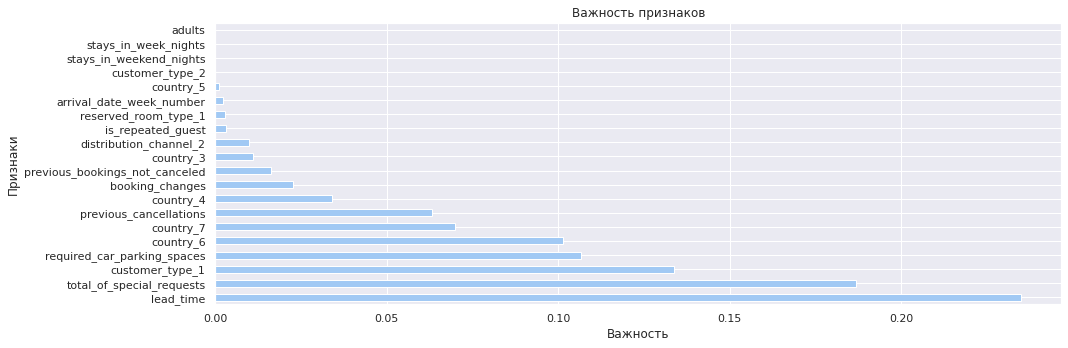

In [75]:
#Посмотрим, какие признаки выделила наша модель
pd.Series(model_dt.feature_importances_, features_train.columns).nlargest(20).plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

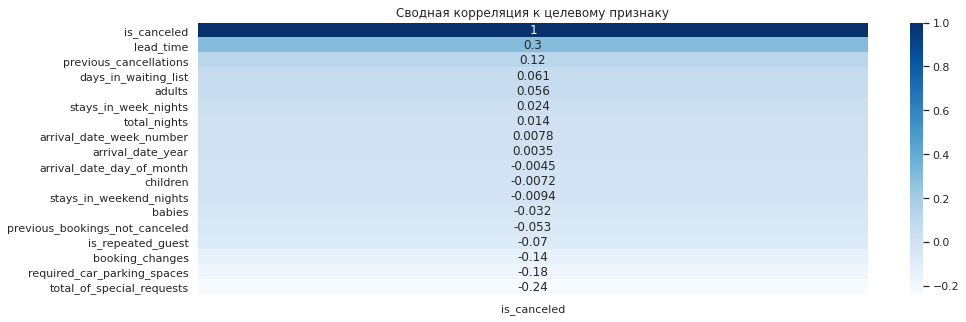

In [76]:
#Проверим корреляцию между признаками к целевому признаку на обобщенном датафрейме
hotel_concat = pd.concat([hotel_train, hotel_test])
sns.heatmap(hotel_concat.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
plt.title('Сводная корреляция к целевому признаку')
plt.show()

Из тех значений, что не подверглись кодированию, мы можем отметить следующие зависимости, на которые обратила внимание модель:

- Чем больше времени между бронированием и выездом, тем выше вероятность отказа. Есть время передумать.
- Чем больше специальных отметок, тем ниже вероятность отказа. Гости, которые оставляют отметки или пожелания, заинтересованы в том, чтобы снять номер.
- Если есть требования к парковочным местам, то вероятность отказа от бронирования ниже. Если человек едет на машине, значит путешествие, скорее всего, запланировано и меньше соблазна отменять бронь.
- Если есть отмены брони, то есть и вероятность отказа. У клиента наблюдается модус поведения.
- Чем больше было неотмененных броней у клиента ранее, тем ниже вероятность отмены.
- Чем выше количество изменений параметров заказа, тем ниже вероятность отмены брони. Опять же, если человек оставляет какие то требования, то значит он, скорее всего, заинтересован в брони.
- Если гость до этого бронировал номер, то ниже вероятность отмены в дальнейшем. значит клиент проверенный.
- Время года также имеет значение.

Далее рассмотрим поближе категориальные признаки и их зависимости.

In [77]:
#Добавим к рассматриваемому датасету столбец с предсказаниями, чтобы делать сравнительные таблицы
prediction_dt = pd.Series(prediction_dt).to_frame()
prediction_dt.columns = ['prediction_dt']
hotel_test = hotel_test.merge(prediction_dt, left_index=True, right_index=True)
hotel_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prediction_dt
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32400,0,164.0,2017,August,35,31,2,4,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1
32401,0,21.0,2017,August,35,30,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,0
32402,0,23.0,2017,August,35,30,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1
32403,0,34.0,2017,August,35,31,2,5,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,0


In [78]:
#Создадим функцию для сравнения кат признаков относительно фактическому и предсказанному целевому признаку
def cat_comparison(column):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(f'Сравнение зависимости отмены бронирования от категорий {column}', fontweight="bold")
    sns.barplot(data=hotel_test, x=column, y='is_canceled', ax=ax[0])
    ax[0].set_title('Фактические отмены')
    ax[0].set_xlabel('Категории')
    ax[0].set_ylabel('Зависимость целевого признака')
    sns.barplot(data=hotel_test, x=column, y='prediction_dt', ax=ax[1])
    ax[1].set_title('Предсказанные отмены')
    ax[1].set_xlabel('Категории')
    ax[1].set_ylabel('Зависимость целевого признака')
    plt.show()
    val_counts = hotel_train.value_counts(column).to_frame()
    val_counts.columns = ['share']
    val_counts['share'] = (val_counts['share'] / val_counts['share'].sum()).apply(lambda x: '{0:.2%}'.format(x))
    display(val_counts)

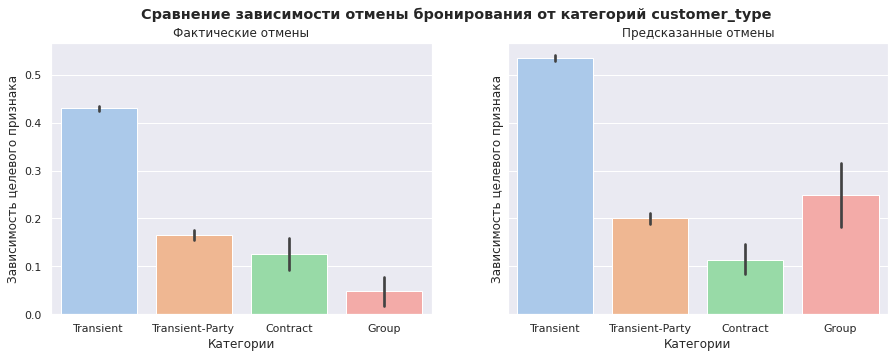

,share
customer_type,
Transient,69.74%
Transient-Party,25.61%
Contract,4.21%
Group,0.44%


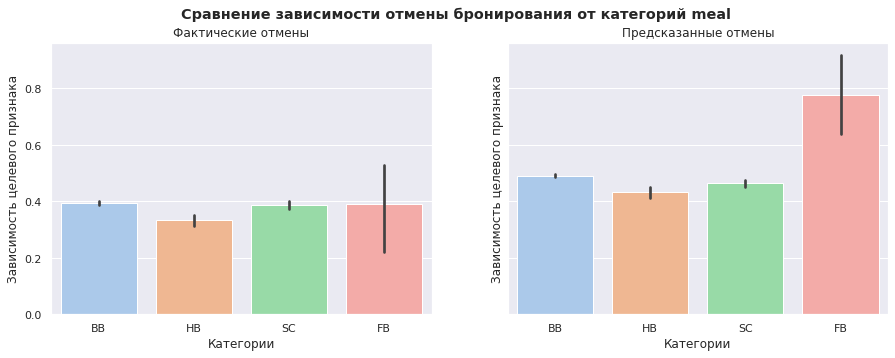

,share
meal,
BB,79.27%
HB,11.18%
SC,8.86%
FB,0.69%


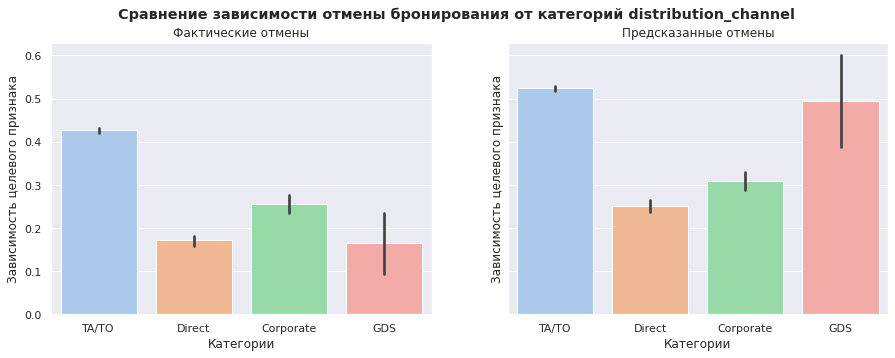

,share
distribution_channel,
TA/TO,83.48%
Direct,10.50%
Corporate,5.86%
GDS,0.15%


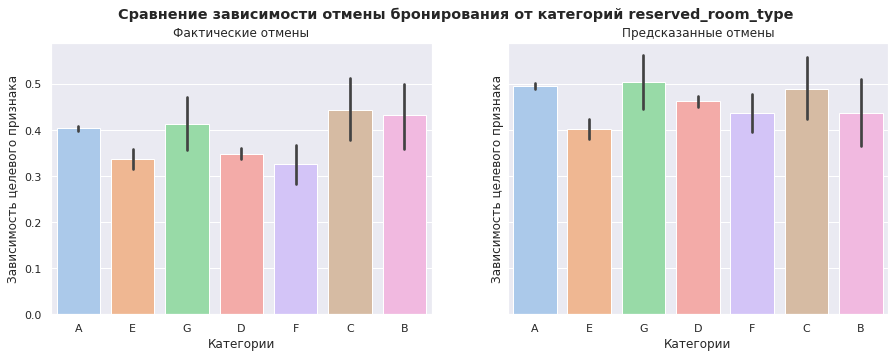

,share
reserved_room_type,
A,77.42%
D,14.39%
E,3.75%
F,1.86%
B,1.32%
G,0.91%
C,0.35%


In [79]:
cols = ['customer_type', 'meal', 'distribution_channel', 'reserved_room_type']
for col in cols:
    cat_comparison(col)

Выводы по категориальным столбцам:

- По типу заказчика больше всех отменяет категория Transient, но модель сместила выбор в пользу самой низкой - Group, что не так важно, учитывая общую долю этой категории менее 1%.
- По категориям meal у нас нет особых скачков, все категории где-то на уровне 0,4. Модель отдала предпочтение категории FB, что также незначительно, тк она занимает менее 1% и вряд ли способна навредить метрикам предсказаний.
- По категориям distribution_channel выделяются TA/TO и Corporate. Что касается модели, то наблюдается та же картина, что и в предыдущих категориях - заметен скачок на категории GDS, которая занимает менее 1%.
- По reserved_room_type мы уже отмечали, что отменяют в основном категории А, В, С, G. Модель в общих чертах воспроизвела эти зависимости.

Как у нас обстоят дела с категориями country?

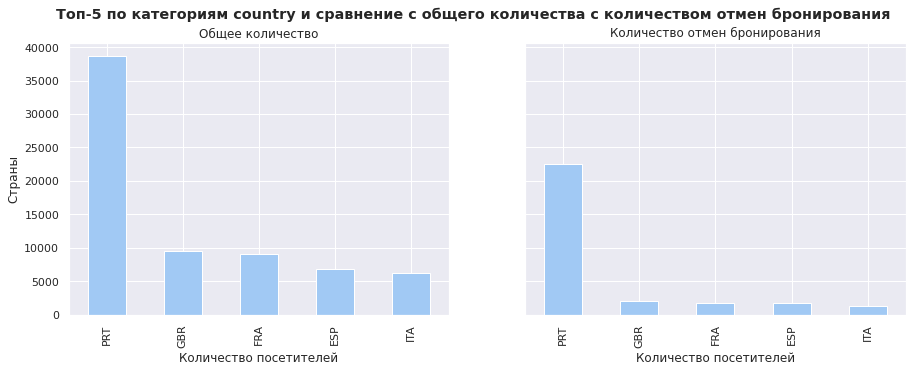

In [80]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Топ-5 по категориям country и сравнение с общего количества с количеством отмен бронирования', fontweight="bold")
hotel_concat.value_counts('country').nlargest(5).plot(kind='bar', ax=ax[0])
ax[0].set_title('Общее количество')
ax[0].set_xlabel('Количество посетителей')
ax[0].set_ylabel('Страны')
hotel_concat.query('is_canceled == 1')['country'].value_counts().nlargest(5).plot(kind='bar', ax=ax[1])
ax[1].set_title('Количество отмен бронирования')
ax[1].set_xlabel('Количество посетителей')
plt.show()

Как видим, большинство посетителей приезжает из Португалии. Около половины из них отменяет бронирование. И это идет вразрез с практикой уроженцев других стран.

Какие выводы можно сделать насчет "ненадежных клиентов":

- На ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа.
- В то же время есть признаки-"якори", которые снижают вероятность отмены - долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента.
- Конечно же, забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F.
- Львиную долю гостей составляют посетители из Португалии, которые, к тому же, непропорционально часто отменяют брони.

### Шаг 6. Напишите общий вывод

Итак, мы провели исследование, спрогнозировали отток клиентов, подведем итог:

- Мы провели предобработку данных, удалили лишний столбец id, неинформативный в нашем деле, выявили дубликаты, которые решено было оставить, тк мы не знаем их истинную природу. Также исправили категориальные значения, в которых были ошибки и удалили единичные строки с нулевым количеством постояльцев.
- В исследовательском анализе мы выявили дисбаланс целевого признака, отменяется 37-39 % брони. В дальнейшем при обучении модели данная проблема была решена. Выяснили, что столбец с непрерывными значениями lead_time имеет логнормальное распределение и выбросы. Имеет средний показатель 97,5. Этот признак больше всего коррелирует с целевым. В нем удалили выбросы, как и в столбце total_nights. Остальные признаки мы не трогали.
- Узнали, что пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.
- Далее подготовили данные для ML, очистили вышеозначенные столбцы от выбросов, разделили на признаки, в некоторых столбцах выявили категории более четко, провели масштабирование и кодирование через Binary Encoder нашей тренировочной выборки. Увеличили ее за счет увеличения положительного целевого признака. Но сделали это не для балансировки, но для увеличения тренировочной выборки, которая была очень мала по сравнению с тестовой.
- Далее мы обучили наши модели. Выбрали три: лог регрессия, дерево решений, случайный лес. В качестве целевой метрики выбрали recall, тк нам было важно не отправить потенциальных отказников в список тех, кто точно не откажется от брони. Ведь именно в этом случае мы теряли деньги.
- Из созданных моделей лучше всего была модель случайного леса с самым высоким показателем ROC_AUC и F1, но она нас не устраивала по показателю recall, который, как известно, был целевым. Поэтому мы будем использовать модель дерева решений, которая лишь слегка хуже, но у которой recall на тестовой выборке выдал 0,772. Это помогло бы нам увеличить прибыль на тестовой выборке до 11 млн руб. И это является достижением и позволяет окупить затраты в 400_000 руб на создание модели. Модель сохранили в файл decision_tree.pkl.
- Оценивая портрет "ненадежного" заемщика пришли к выводу, что на ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа. В то же время долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента. Конечно же, забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F.
- Особенно стоит обратить внимание на посетителей из Португалии. Они составляют значительную долю бронирований в отеле, но и частенько (около половины общего количества) их отменяют. Возможно, стоит отдельно выделить данную категорию гостей и понаблюдать. Если доля отмен будет увеличиваться, обложить их депозитом отдельно. Впрочем, модель и так достаточно хорошо предсказывает отмены.